# Version 1

In [1]:
# %% [markdown]
# # ML Pipeline using ExtraTreesClassifier
# This notebook demonstrates a complete data science workflow:
# - Data exploration and preprocessing
# - Feature engineering
# - Model training with ExtraTrees
# - Evaluation and visualization of feature importance

# %%
# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import ExtraTreesClassifier

# %%
# 2. Data Loading & Exploration
# Assume df is already loaded. For example, if reading from a CSV:
# df = pd.read_csv('your_data.csv')

def explore_data(df):
    """
    Display basic information and missing values.
    """
    print("Dataframe Head:")
    print(df.head())
    print("\nDataframe Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

# %%
# 3. Preprocessing & Feature Engineering

def preprocess_data(df):
    """
    Preprocess the dataframe by:
    - Dropping non-informative columns (e.g., Id)
    - Encoding categorical features and target variable
    - Returning X (features) and y (target)
    """
    # Drop the Id column if it exists
    if 'Id' in df.columns:
        df = df.drop(columns=['Id'])
    
    # Identify categorical columns (excluding the target for separate handling)
    categorical_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 
                        'Profession', 'CITY', 'STATE']
    
    # Copy the dataframe to avoid modifying original data
    df_processed = df.copy()
    
    # Encode the target variable using LabelEncoder
    if df_processed['Risk_Flag'].dtype == 'object' or str(df_processed['Risk_Flag'].dtype).startswith('category'):
        le_target = LabelEncoder()
        df_processed['Risk_Flag'] = le_target.fit_transform(df_processed['Risk_Flag'])
    else:
        le_target = None
    
    # For categorical features, decide on encoding:
    # For simplicity, use one-hot encoding if cardinality is low. 
    # Adjust strategy if some variables have high cardinality.
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    # Separate features and target
    X = df_processed.drop(columns=['Risk_Flag'])
    y = df_processed['Risk_Flag']
    
    return X, y, le_target

# %%
# 4. Split data and train ExtraTrees model

def train_extra_trees(X, y, test_size=0.2, random_state=42):
    """
    Split the data into training and testing sets,
    then train an ExtraTreesClassifier.
    Returns the trained model and the split datasets.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y)
    # Initialize ExtraTreesClassifier
    model = ExtraTreesClassifier(n_estimators=100, random_state=random_state)
    
    # Train the model
    model.fit(X_train, y_train)
    
    return model, X_train, X_test, y_train, y_test

# %%
# 5. Evaluate the Model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model performance on test data.
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)
    
    return acc, cm, report

# %%
# 6. Plot Feature Importances

def plot_feature_importances(model, X):
    """
    Plot feature importances as computed by the ExtraTrees model.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[indices], y=features[indices])
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# %%
# 7. Main pipeline execution

def main(df):
    # Explore data
    print("=== Data Exploration ===")
    explore_data(df)
    
    # Preprocess data
    print("\n=== Preprocessing & Feature Engineering ===")
    X, y, le_target = preprocess_data(df)
    print(f"Shape of features after encoding: {X.shape}")
    
    # Train model
    print("\n=== Training ExtraTreesClassifier ===")
    model, X_train, X_test, y_train, y_test = train_extra_trees(X, y)
    
    # Feature Importance
    print("\n=== Feature Importances ===")
    plot_feature_importances(model, X)
    
    # Evaluate model
    print("\n=== Model Evaluation ===")
    evaluate_model(model, X_test, y_test)



=== Data Exploration ===
Dataframe Head:
            Id   Income  Age  Experience Married/Single House_Ownership  \
75255    75256  4260981   47          18         single          rented   
192435  192436  8529345   44           2         single          rented   
154839  154840  7848654   55           9         single          rented   
59774    59775  8491491   61          20         single          rented   
63788    63789  1537266   78          13         single          rented   

       Car_Ownership                  Profession          CITY  \
75255             no                  Politician      Hindupur   
192435            no  Computer_hardware_engineer  Narasaraopet   
154839            no          Software_Developer         Patna   
59774             no                    Comedian        Haldia   
63788             no                Web_designer    Coimbatore   

                 STATE  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS Risk_Flag  
75255   Andhra_Pradesh                7 

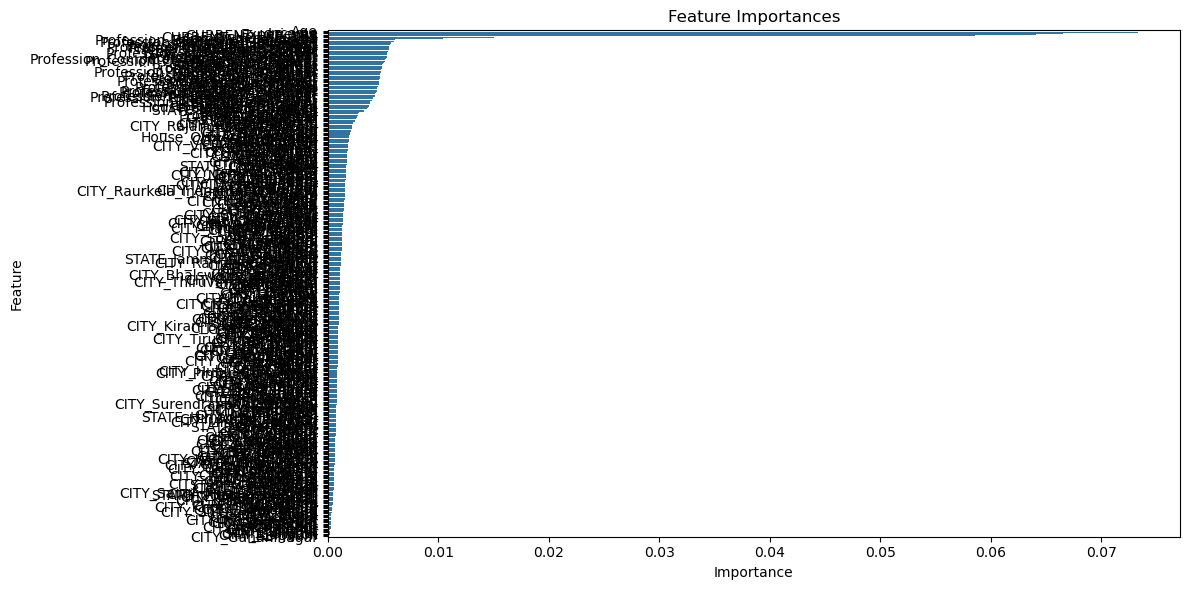


=== Model Evaluation ===
Accuracy: 0.8837
Confusion Matrix:
[[ 297  331]
 [ 255 4157]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.47      0.50       628
           1       0.93      0.94      0.93      4412

    accuracy                           0.88      5040
   macro avg       0.73      0.71      0.72      5040
weighted avg       0.88      0.88      0.88      5040



In [3]:
import pickle

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        # Redirect module if it is the old numpy internal module
        if module == "numpy._core.numeric":
            module = "numpy.core.numeric"
        return super().find_class(module, name)

# Use the custom unpickler to load your pickle file
with open('../data/processed/df_loan.pkl', 'rb') as f:
    df = CustomUnpickler(f).load()

# Take a sample as before
df = df.sample(frac=0.1, random_state=42)
main(df)


# Version 2

In [10]:
# %% [markdown]
# # Improved ML Pipeline with ExtraTreesClassifier, SMOTE, and Hyperparameter Tuning
#
# This notebook implements an enhanced data science workflow including:
# - Data exploration and preprocessing with feature engineering
# - Handling class imbalance using SMOTE
# - Hyperparameter tuning using GridSearchCV with cross-validation
# - Model evaluation and feature importance visualization

# %%
# 1. Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import ExtraTreesClassifier

# Import SMOTE from imblearn
from imblearn.over_sampling import SMOTE

# %%
# 2. Data Exploration Function

def explore_data(df):
    """
    Display basic information and missing values for the dataframe.
    """
    print("Dataframe Head:")
    print(df.head())
    print("\nDataframe Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())

# %%
# 3. Preprocessing & Feature Engineering Function

def preprocess_data(df):
    """
    Preprocess the dataframe:
    - Drop non-informative columns (e.g., Id)
    - Encode categorical features and target variable
    - One-hot encode features with low cardinality.
    Returns features X, target y, and the target encoder (if used).
    """
    # Drop the Id column if it exists
    if 'Id' in df.columns:
        df = df.drop(columns=['Id'])
    
    # List of categorical feature columns (excluding target)
    categorical_cols = ['Married/Single', 'House_Ownership', 'Car_Ownership', 
                        'Profession', 'CITY', 'STATE']
    
    df_processed = df.copy()
    
    # Encode target variable (Risk_Flag) if necessary
    if df_processed['Risk_Flag'].dtype == 'object' or str(df_processed['Risk_Flag'].dtype).startswith('category'):
        le_target = LabelEncoder()
        df_processed['Risk_Flag'] = le_target.fit_transform(df_processed['Risk_Flag'])
    else:
        le_target = None
    
    # One-hot encode categorical features
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    # Separate features and target
    X = df_processed.drop(columns=['Risk_Flag'])
    y = df_processed['Risk_Flag']
    
    return X, y, le_target

# %%
# 4. Model Training with Hyperparameter Tuning and SMOTE

def train_extra_trees(X, y, test_size=0.2, random_state=42):
    """
    Split data, apply SMOTE to address class imbalance,
    and perform hyperparameter tuning with GridSearchCV on an ExtraTreesClassifier.
    Returns the best model along with the split data.
    """
    # Split data (using stratification to maintain class distribution)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y)
    
    # Handle class imbalance using SMOTE on training data
    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("After SMOTE, class distribution:")
    print(pd.Series(y_train_res).value_counts())
    
    # Define the ExtraTreesClassifier and hyperparameter grid for tuning
    etc = ExtraTreesClassifier(random_state=random_state)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    
    # Use stratified k-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    grid_search = GridSearchCV(estimator=etc,
                               param_grid=param_grid,
                               cv=cv,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)
    
    # Fit grid search on resampled training data
    grid_search.fit(X_train_res, y_train_res)
    
    print("Best parameters found:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    
    return best_model, X_train, X_test, y_train, y_test

# %%
# 5. Model Evaluation Function

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model performance on test data.
    Prints accuracy, confusion matrix, and classification report.
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)
    
    return acc, cm, report

# %%
# 6. Feature Importance Visualization Function

def plot_feature_importances(model, X, top_n=15):
    """
    Plot the top N feature importances as computed by the ExtraTrees model.
    
    Parameters:
    model -- Trained model with feature_importances_ attribute
    X -- DataFrame with feature names
    top_n -- Number of top features to display (default: 15)
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]  # Get top N indices
    features = X.columns[indices]  # Select corresponding feature names
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[indices], y=features)
    plt.title(f"Top {top_n} Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# %%
# 7. Main Pipeline Function

def main(df):
    # Data exploration
    print("=== Data Exploration ===")
    explore_data(df)
    
    # Preprocessing and feature engineering
    print("\n=== Preprocessing & Feature Engineering ===")
    X, y, le_target = preprocess_data(df)
    print("Shape of features after encoding:", X.shape)
    
    # Train the model with hyperparameter tuning and SMOTE
    print("\n=== Training ExtraTreesClassifier with GridSearchCV & SMOTE ===")
    model, X_train, X_test, y_train, y_test = train_extra_trees(X, y)
    
    # Visualize feature importances
    print("\n=== Feature Importances ===")
    plot_feature_importances(model, X)
    
    # Evaluate model on the test set
    print("\n=== Model Evaluation ===")
    evaluate_model(model, X_test, y_test)



In [ ]:
import pickle

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        # Redirect module if it is the old numpy internal module
        if module == "numpy._core.numeric":
            module = "numpy.core.numeric"
        return super().find_class(module, name)

# Use the custom unpickler to load your pickle file
with open('../data/processed/df_loan.pkl', 'rb') as f:
    df = CustomUnpickler(f).load()

# Take a sample as before
df = df.sample(frac=0.1, random_state=42)
results=main(df)


=== Data Exploration ===
Dataframe Head:
            Id   Income  Age  Experience Married/Single House_Ownership  \
75255    75256  4260981   47          18         single          rented   
192435  192436  8529345   44           2         single          rented   
154839  154840  7848654   55           9         single          rented   
59774    59775  8491491   61          20         single          rented   
63788    63789  1537266   78          13         single          rented   

       Car_Ownership                  Profession          CITY  \
75255             no                  Politician      Hindupur   
192435            no  Computer_hardware_engineer  Narasaraopet   
154839            no          Software_Developer         Patna   
59774             no                    Comedian        Haldia   
63788             no                Web_designer    Coimbatore   

                 STATE  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS Risk_Flag  
75255   Andhra_Pradesh                7 

In [9]:
main(df).feature_importances_

=== Data Exploration ===
Dataframe Head:
            Id   Income  Age  Experience Married/Single House_Ownership  \
75255    75256  4260981   47          18         single          rented   
192435  192436  8529345   44           2         single          rented   
154839  154840  7848654   55           9         single          rented   
59774    59775  8491491   61          20         single          rented   
63788    63789  1537266   78          13         single          rented   

       Car_Ownership                  Profession          CITY  \
75255             no                  Politician      Hindupur   
192435            no  Computer_hardware_engineer  Narasaraopet   
154839            no          Software_Developer         Patna   
59774             no                    Comedian        Haldia   
63788             no                Web_designer    Coimbatore   

                 STATE  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS Risk_Flag  
75255   Andhra_Pradesh                7 

KeyboardInterrupt: 